In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
import os

## Read in data from loops

directory_path = r'/Users/rprocious/Waterlevels_CBI/CBI-2/Corrected_Data_Official/nesscanResult_removedBadNesdisRecords/Pier21'
dataframes = []


for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('.csv'):

        file_path = os.path.join(directory_path, filename)
        
        df = pd.read_csv(
        file_path,
        parse_dates=[0],
        na_values=[-999, -99, 99, 'NA', 'RM'],
        engine='python'   
        )
        df.columns = ['station #','date', 'pwl',]
        dataframes.append(df)

p21 = pd.concat(dataframes, ignore_index=True)

directory_path = r'/Users/rprocious/Waterlevels_CBI/CBI-2/data 2/NOAA/pier21'
dataframes = []

# Loop through the files in the directory
for filename in sorted(os.listdir(directory_path)):
    if filename.endswith('level.csv'):

        file_path = os.path.join(directory_path, filename)
        
        
        df = pd.read_csv(file_path)
        
        dataframes.append(df)

#formats the dataframes
p21_NOAA = pd.concat(dataframes, ignore_index=True)
p21_NOAA.drop(labels=range(0,3), axis = 0,inplace=True)
p21_NOAA.reset_index(drop = True, inplace=True)
p21['date'] = pd.to_datetime(p21['date'])
p21_NOAA['date'] = pd.to_datetime(p21_NOAA['Date Time'],errors='coerce')
p21 = p21.merge(p21_NOAA,on='date',how='outer')
p21.drop(labels=range(0,2), axis = 0,inplace=True)
p21.reset_index(drop = True, inplace=True)
p21['offset'] = p21['pwl'] - p21[' Water Level']
p21 = p21.drop(columns='Date Time', axis= 0)
p21 = p21.drop(columns=' Sigma', axis= 0)
p21 = p21.drop(columns=' O or I (for verified)', axis= 0)
p21 = p21.drop(columns=' F', axis= 0)
p21 = p21.drop(columns=' R', axis= 0)
p21 = p21.drop(columns=' L', axis= 0)
p21 = p21.drop(columns=' Quality ', axis= 0)

/var/folders/y3/cr8y1g617l16hvdtqnqzmgz80000gn/T/ipykernel_1378/529805786.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(
/var/folders/y3/cr8y1g617l16hvdtqnqzmgz80000gn/T/ipykernel_1378/529805786.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(


In [2]:
offset = pd.DataFrame()
offset['values'] = p21['offset']
offset['date'] = p21['date']
offset.replace(0, pd.NA, inplace=True)
offset = offset.dropna()
offset['change'] = (offset['values'] != offset['values'].shift()).cumsum()

result = offset.groupby('change').agg(
    start_index=('change', 'idxmin'),
    end_index=('change', 'idxmax'),
    start_date = ('date','first'),
    end_date = ('date','last'),
    length=('values', 'size'),
    value=('values', 'first')
).reset_index(drop=True)
# Drop the helper column if necessary
offset = offset.drop(columns=['change'])

result = result[result['length']>=10]

result.to_clipboard()

In [3]:
p21[2238710:2238719]

,station #,date,pwl,Water Level,offset
2238710,022,2018-01-10 16:06:00,6.997,1.697,5.300
2238711,022,2018-01-10 16:12:00,6.997,1.696,5.301
2238712,NaN,2018-01-10 16:18:00,NaN,1.702,NaN
2238713,NaN,2018-01-10 16:24:00,NaN,1.715,NaN
2238714,NaN,2018-01-10 16:30:00,NaN,1.718,NaN
2238715,022,2018-01-10 16:36:00,1.651,1.718,-0.067
2238716,022,2018-01-10 16:42:00,1.659,1.726,-0.067
2238717,NaN,2018-01-10 16:48:00,NaN,1.734,NaN
2238718,022,2018-01-10 16:54:00,1.674,1.741,-0.067


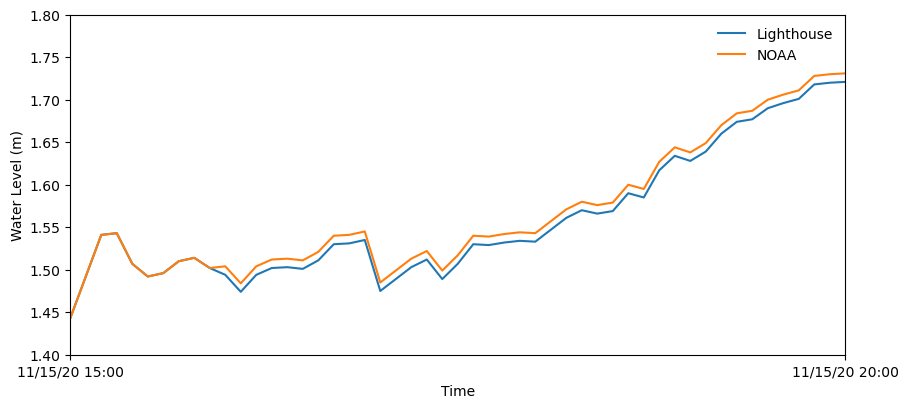

In [10]:

start_date = pd.to_datetime('11/15/20 15:00')
end_date = pd.to_datetime('11/15/20 20:00')

# Filter the data to only include the xlim range
filtered_data = p21[(p21['date'] >= start_date) & (p21['date'] <= end_date)]

# Plot the filtered data
plt.figure(figsize=(10,5))
plt.plot(filtered_data['date'], filtered_data['pwl'], label='Lighthouse')
plt.plot(filtered_data['date'], filtered_data[' Water Level'], label='NOAA')


plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%D %H:%M'))

# Set tick locator for hourly intervals
plt.gca().xaxis.set_major_locator(mdates.MinuteLocator(interval=6500))
# Autofmt the x-axis labels
plt.gcf().autofmt_xdate()

plt.xticks(rotation=0)

for label in plt.gca().get_xticklabels():
    label.set_ha('center')  # Set horizontal alignment to center

# Adjust y-axis limits
plt.ylim(1.4,1.8)

# Set x-axis limits
plt.xlim(start_date, end_date)

# Add legend and title
plt.legend(frameon=False)
plt.xlabel('Time')
plt.ylabel('Water Level (m)')

# Display the plot
plt.show()